<a href="https://colab.research.google.com/github/phas-ml/phas-ml.github.io/blob/master/notebooks/2021_09_30_dcgan_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
**Jordan McGinn - 2021**

This notebook will give an introduction to generative adversarial networks (GANs). We will use a varient of GANs called deep convolutional generative adverserial networks (DCGANs) simply because it works much better in practice than the "vanilla" method but also it shouldn't be too much of a jump in complexity. We will use a DCGAN to generate pictures of clothes. No prior knowledge of GANs is needed but you might have to stop and reason with whats happening in the guts of the training process. GPU is pretty much essential, so colab is a good shout! We'll be writing this in pytorch and the whole tutorial is heavly influenced from the [pytorch tutorials page](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

## What is a GAN?



GANs are a framework for teaching a DL model to capture the training
data’s distribution so we can generate new data from that same
distribution. GANs were invented by Ian Goodfellow in 2014 and first
described in the paper [Generative Adversarial
Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).
GANs are a clever way of training a generative model by framing the problem as a supervised learning problem with two sub-models: the generator model that we train to generate new examples, and the discriminator model that tries to classify examples as either real (from the domain) or fake (generated). The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.


Now, lets define some notation to be used throughout tutorial starting
with the discriminator. Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator. Here, since we are dealing with images, the input to
$D(x)$ is an image of CHW size 1x64x64. Intuitively, $D(x)$
should be HIGH when $x$ comes from training data and LOW when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training
data comes from ($p_{data}$) so it can generate fake samples from
that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image. As described in Goodfellow’s
paper,
$D$ and $G$ play a minimax game in which $D$ tries to
maximize the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to minimize the probability that
$D$ will predict its outputs are fake ($log(1-D(G(z)))$).
From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

In theory, the solution to this minimax game is where
$p_g = p_{data}$, and the discriminator guesses randomly if the
inputs are real or fake. However, the convergence theory of GANs is
still being actively researched and in reality models do not always
train to this point.

Proof?
------
Let, y = true label on the data. 1 for real and 0 for fake.

  $\hat{y}$ = prediction from the network [0,1]
\begin{equation}
  L_{BCE} = y \log(\hat{y}) + (1 - y) \log(1-\hat{y})
\end{equation}

Training $D$: We set y = 1 and $\hat{y}$ = $D(x)$,

-> $L_{D}$ = $\log D(x)$ 

Training $G$: We set y = 0 and $\hat{y}$ = $D(G(z))$

-> $L_{G}$ = $\log(1-D(G(z)))$

Since we want to maximise $D(x)$ (the discriminators predictions on real data) we want to maximise $L_{D}$. And since we also want to maximise the generators performance $D(G(z))$ then we will want to minimise $L_{G}$.
What is a DCGAN?
----------------

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. It was first described by
Radford et. al. in the paper [Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial
Networks](https://arxiv.org/pdf/1511.06434.pdf). The discriminator
is made up of strided
[convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)
layers, [batch
norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)
layers, and
[LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU)
activations. The input is a 3x64x64 input image and the output is a
scalar probability that the input is from the real data distribution.
The generator is comprised of
[convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d)
layers, batch norm layers, and
[ReLU](https://pytorch.org/docs/stable/nn.html#relu) activations. The
input is a latent vector, $z$, that is drawn from a standard
normal distribution and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. In the paper, the authors also
give some tips about how to setup the optimizers, how to calculate the
loss functions, and how to initialize the model weights, all of which
will be explained in the coming sections.



Human faces example
-------------------
https://thispersondoesnotexist.com

# Imports

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision
from torchvision import datasets, transforms
import time

# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2644


## Setups

In [ ]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Data

We'll use the FASHION MNIST dataset. The dataset consists of black and white images of 10 classes of clothing. We resize the data to (channel,width,height) = (1,64,64) where we only need a 1 in the channel entry represents the intensity of each pixel. For colour images we would use 3 for the RGB value. Lukily we can dowload this straight forwardly usign pytorch data loaders. As an optional extra you can choose to use a subset of the LSUN data set which contains colour images of restaraunts. WARNING this takes a while to dowload, unzip and train. ~15 mins for download/unzip and a few hours to train for 5 epochs. I've included model i trained for 5 epochs on this dataset if you want to explore that. 

In [ ]:
# optional restaurant LSUN dataset
'''
!mkdir data
!wget http://dl.yf.io/lsun/scenes/restaurant_train_lmdb.zip 
!unzip restaurant_train_lmdb.zip -d data

dataset = datasets.LSUN(root=dataroot,classes=['restaurant_train'],
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''

"\n!mkdir data\n!wget http://dl.yf.io/lsun/scenes/restaurant_train_lmdb.zip \n!unzip restaurant_train_lmdb.zip -d data\n\ndataset = datasets.LSUN(root=dataroot,classes=['restaurant_train'],\n                           transform=transforms.Compose([\n                               transforms.Resize(image_size),\n                               transforms.CenterCrop(image_size),\n                               transforms.ToTensor(),\n                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),\n                           ]))\n"

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


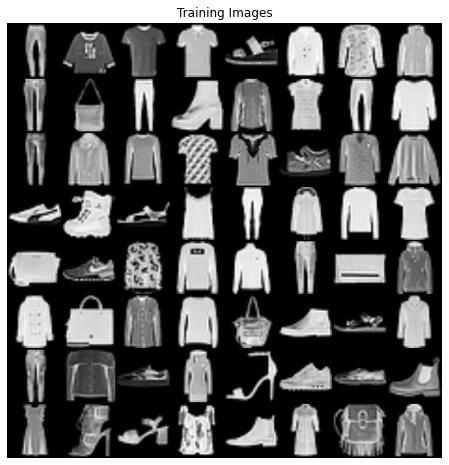

In [ ]:
# Create the dataset
dataset = datasets.FashionMNIST(root='data/',download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

## Implementation

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

## Weight Initialization

The DCGAN authors specify to inistalize the weights of the networks to be normally distributed. 

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Activations

Activation functions define the output of a layer in response to an input. Nonlinear activation functions allow neural networks to compute nontrivial problems using only a small number of nodes, and such activation functions are called nonlinearities. Below are some activation functions used in this GAN.

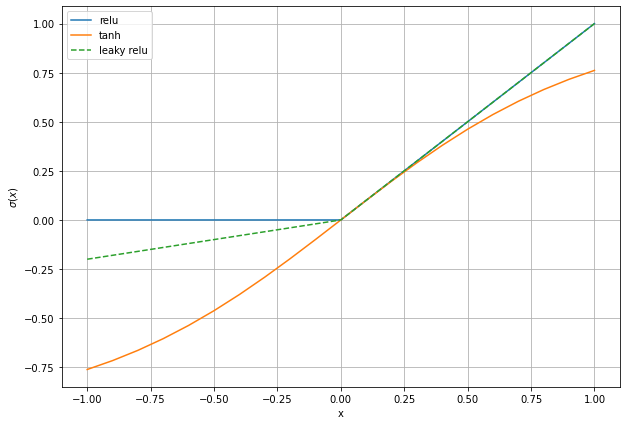

In [ ]:
plt.figure(figsize=(10,7))
x = torch.arange(-1, 1.1, 0.1)

a = nn.ReLU()
b = nn.Tanh()
c = nn.LeakyReLU(0.2)

plt.plot(x, a(x), label='relu')
plt.plot(x, b(x), label='tanh')
plt.plot(x, c(x), label='leaky relu', linestyle='--')
plt.ylabel('$\sigma (x)$')
plt.xlabel('x')
plt.legend()
plt.grid()
plt.show()

Generator
---------

The generator, $G$, is designed to map the latent space vector
($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating an image with the
same size as the training images (i.e. 1x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training.

Notice, the how the inputs we set in the input section (*nz*, *ngf*, and
*nc*) influence the generator architecture in code. *nz* is the length
of the z input vector, *ngf* relates to the size of the feature maps
that are propagated through the generator, and *nc* is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.



In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator
-------------

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 1x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers
-----------------------------

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>))
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training
--------

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in [ganhacks](<https://github.com/soumith/ganhacks).
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.





In [ ]:
start_time = time.time()

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        torch.save(netG.state_dict(), '../data')
        iters += 1
        
print("--- train time: %s minutes ---" % (int(time.time() - start_time)/60.))

Starting Training Loop...
[0/2][0/469]	Loss_D: 1.3883	Loss_G: 4.7045	D(x): 0.5535	D(G(z)): 0.4581 / 0.0144
[0/2][50/469]	Loss_D: 0.0904	Loss_G: 8.4517	D(x): 0.9600	D(G(z)): 0.0191 / 0.0003
[0/2][100/469]	Loss_D: 0.3159	Loss_G: 4.4211	D(x): 0.8344	D(G(z)): 0.0752 / 0.0198
[0/2][150/469]	Loss_D: 0.1822	Loss_G: 4.0278	D(x): 0.8984	D(G(z)): 0.0387 / 0.0281
[0/2][200/469]	Loss_D: 0.2685	Loss_G: 3.5223	D(x): 0.8373	D(G(z)): 0.0391 / 0.0524
[0/2][250/469]	Loss_D: 0.2235	Loss_G: 3.3599	D(x): 0.8895	D(G(z)): 0.0771 / 0.0574
[0/2][300/469]	Loss_D: 0.1644	Loss_G: 5.3498	D(x): 0.9187	D(G(z)): 0.0566 / 0.0117
[0/2][350/469]	Loss_D: 0.3680	Loss_G: 4.6839	D(x): 0.9406	D(G(z)): 0.2341 / 0.0198
[0/2][400/469]	Loss_D: 0.4248	Loss_G: 4.1998	D(x): 0.8993	D(G(z)): 0.2316 / 0.0334
[0/2][450/469]	Loss_D: 0.4570	Loss_G: 2.4007	D(x): 0.8109	D(G(z)): 0.1685 / 0.1235
[1/2][0/469]	Loss_D: 0.4615	Loss_G: 2.2316	D(x): 0.7072	D(G(z)): 0.0430 / 0.1568
[1/2][50/469]	Loss_D: 0.4237	Loss_G: 1.5326	D(x): 0.7467	D(G(z)): 

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

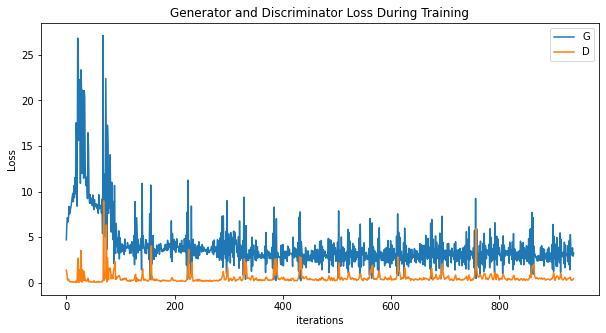

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.



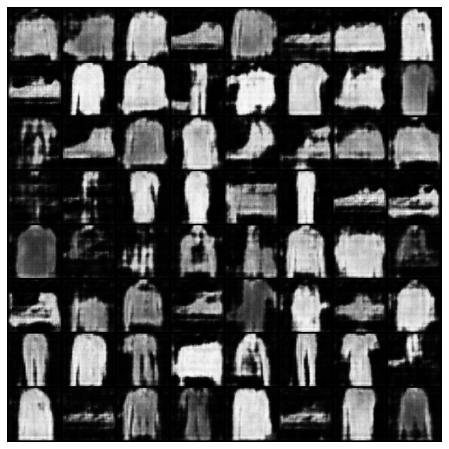

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.



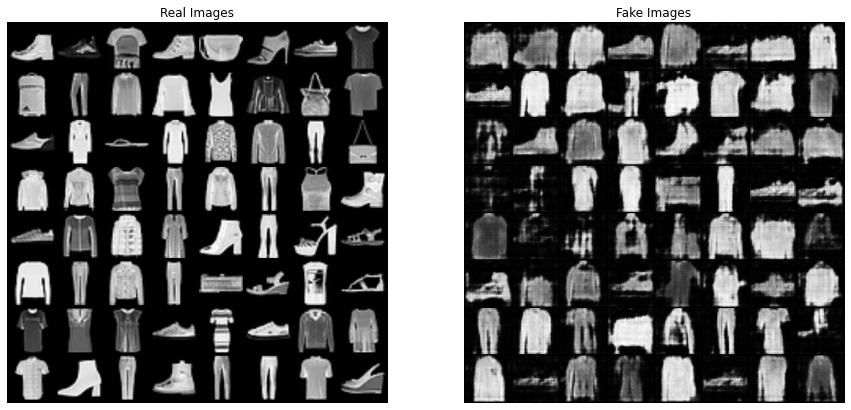

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## Explore the latent space ##

Now that we have a trained generator we can just call this a function. A function that takes in a point in latent space and maps it to an particular black and white picture of an item of clothing. Since the latent space is constructed in a way that it is a "space". That is, a multi dimensional Gaussian space, then we can pick two points in this space and walk through some trajectory between these two points. At each step of the walk we can feed this to our generator function and see how the images changes. This was explore in the DCGAN paper and had quite perculiar properties. A bedroom would morph to the same bedroom but one with a window as an example. Or the layout of the room would change or the bed would change size. This continous mapping has been used to various extent to try and manipulate images and other data types. 

In [ ]:
# first random point in the Gaussian space
noise_1 = np.random.randn(nz)
# second random point in the Gaussian space
noise_2 = np.random.randn(nz)

# create equally space points along some high dimensional path between the two points
interp_noise = np.linspace([noise_1], [noise_2], 10)
interp_noise = np.expand_dims(interp_noise, axis=-1)
interp_noise = torch.from_numpy(interp_noise.reshape(10,100,1,1)).float().to(device)

# use G to create an image at each point
with torch.no_grad():
  interp_fake = netG(interp_noise).detach().cpu()


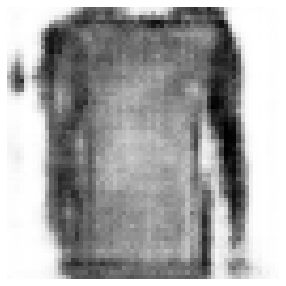

In [ ]:
#%%capture
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(interp_fake[i,0,:,:], animated=True, cmap='Greys')] for i in range(10)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())